Our Model will only be learned from historical data to find pattern.
This disregards other factors like weather or traffic

Statistical Methods: Simple Linear Regression is beginner-friendly
    However, normally they would use Random Forest or XGBoost


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import joblib
import os
from module.openaq_api import *

sns.set(style="whitegrid")

## 1. Fetch Data

In [8]:
country_name = "Cambodia"
country_id = get_country_by_name(country_name)
df = get_historic_data_by_country(country_name, country_id, days=365)
df['time_to'] = pd.to_datetime(df['time_to'])
df = df.set_index('time_to')
df_daily = df.resample('D').mean()
df_daily['value'] = df_daily['value'].interpolate(method='linear')

print(f'Total daily records: {len(df_daily)}')

Loading data from cache: data\cache_57_365d.json
Total daily records: 250


## Stationarity

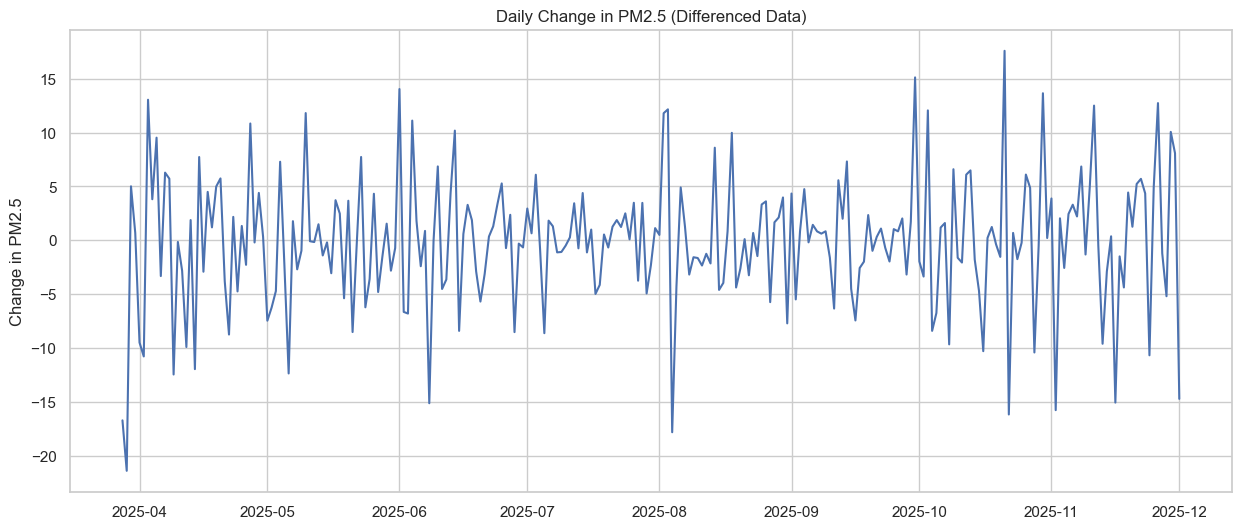

In [10]:
df_daily['diff'] = df_daily['value'].diff()

plt.figure(figsize=(15, 6))
plt.plot(df_daily.index, df_daily['diff'])
plt.title('Daily Change in PM2.5 (Differenced Data)')
plt.ylabel('Change in PM2.5')
plt.show()

## 3. Feature Engineering

In [11]:
def create_features(data):
    df_feat = data.copy()

    # Lags of the DIFFERENCE
    for i in range(1, 8):
        df_feat[f'lag_{i}'] = df_feat['diff'].shift(i)

    df_feat['lag_14'] = df_feat['diff'].shift(14)
    df_feat['lag_30'] = df_feat['diff'].shift(30)

    # Rolling stats on DIFFERENCE
    df_feat['rolling_mean_7'] = df_feat['diff'].shift(1).rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['diff'].shift(1).rolling(window=7).std()

    # Seasonality (Date based)
    df_feat['day_of_week_sin'] = np.sin(2 * np.pi * df_feat.index.dayofweek / 7)
    df_feat['day_of_week_cos'] = np.cos(2 * np.pi * df_feat.index.dayofweek / 7)
    df_feat['day_of_year_sin'] = np.sin(2 * np.pi * df_feat.index.dayofyear / 365.25)
    df_feat['day_of_year_cos'] = np.cos(2 * np.pi * df_feat.index.dayofyear / 365.25)

    return df_feat.dropna()

df_features = create_features(df_daily)    

In [12]:
features = [
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 
    'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_std_7',
    'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos'
]
target = 'diff'

X = df_features[features]
y = df_features[target]

# Split (Shuffle=False for Time Series)
# Always split data sequentially in time series (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [13]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Find the best model 
models=[
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
]

param_grid=[
    {},
    {"max_depth":[3,5,7]},
    {"n_estimators":[50,100,200], "max_depth": [5, 10, 15]},
    {"n_estimators":[100, 500, 1000], "max_depth":[3,5,7], 'learning_rate': [0.01, 0.05, 0.1],}
]

for i, model in enumerate(models):
    grid_search=GridSearchCV(model, param_grid[i], cv=TimeSeriesSplit(n_splits=5), scoring="r2") # cv: cross-validation
    grid_search.fit(X_train_scaled, y_train)
    print(f"{model.__class__.__name__}")
    print("Best parameters: ", grid_search.best_params_)
    print("Best R2 score: ",grid_search.best_score_)
    print()

LinearRegression
Best parameters:  {}
Best R2 score:  -0.023894675006181608

DecisionTreeRegressor
Best parameters:  {'max_depth': 3}
Best R2 score:  -0.3935473583266317

RandomForestRegressor
Best parameters:  {'max_depth': 10, 'n_estimators': 200}
Best R2 score:  0.028739410194126534

XGBRegressor
Best parameters:  {'max_depth': 3, 'n_estimators': 100}
Best R2 score:  -0.3154973785377262



In [37]:
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    xgb, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {search.best_params_}")
model = search.best_estimator_

NameError: name 'XGBRegressor' is not defined

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate on test set
y_pred = search.best_estimator_.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test R2 Score: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test R² Score: 0.0065
Test RMSE: 7.6788
Test MAE: 5.9730


R2 Score (Absolute): 0.45


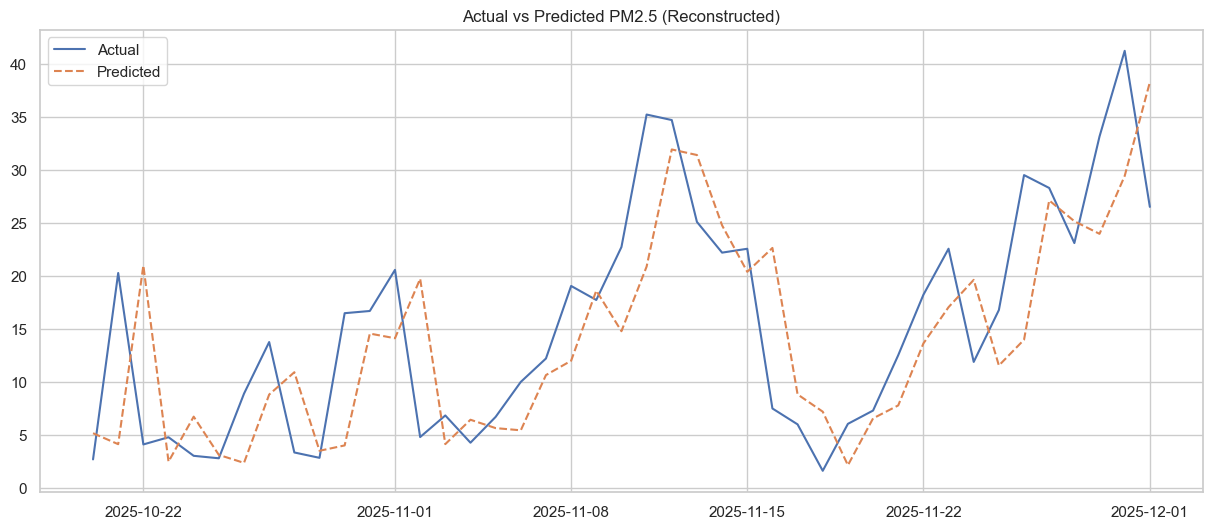

In [18]:
# Predict differences
pred_diff = model.predict(X_test_scaled)

# Reconstruct absolute values
# We need the previous day's ACTUAL value to add the predicted difference
# For the test set, we can use the actual previous values from the original dataframe
test_indices = y_test.index
prev_values = df_daily.loc[test_indices]['value'].shift(1)

# Note: The first value of test set needs the last value of train set
# But since we are using shift(1) on the whole df_daily, it should handle it if indices align
# However, df_features dropped NaNs, so indices might have gaps if not careful.
# Let's align carefully.

prev_values = prev_values.dropna()
# Align lengths
common_indices = prev_values.index.intersection(test_indices)
prev_values = prev_values.loc[common_indices]
pred_diff_series = pd.Series(pred_diff, index=test_indices).loc[common_indices]
y_test_aligned = df_daily.loc[common_indices]['value']

# Reconstruct: Predicted Value = Previous Value + Predicted Diff
pred_values = prev_values + pred_diff_series

# Metrics
mse = mean_squared_error(y_test_aligned, pred_values)
r2 = r2_score(y_test_aligned, pred_values)

print(f"R2 Score (Absolute): {r2:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_aligned.index, y_test_aligned, label='Actual')
plt.plot(y_test_aligned.index, pred_values, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted PM2.5 (Reconstructed)')
plt.legend()
plt.show()

In [ ]:
import pickle
# Define the file name
filename="model.pkl"

# Save the model using pickle
with open(filename,"wb") as file:
    pickle.dump(model,file)
print(f"Model saved to {filename}")

In [ ]:
# Define the filename

filename_scaler="scaler.pkl"

# Save the model using pickle
with open(filename_scaler, "wb") as file:
    pickle.dump(scaler, file)
print(f"Scaler saved to {filename_scaler}")